In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# 파라미터 정의
def param_squeezing(pump, b_freq_p, a_freq, b_freq, b_loss, J0):
    beta = pump/b_freq_p
    rp = (1/4) * np.log((1 + beta) / (1 - beta))
    bs_freq = np.sqrt(1-beta**2)*b_freq_p + b_freq - b_freq_p
    a_freq_bs = a_freq - bs_freq
    noise = (2 * np.sinh(rp)**2 * b_loss)
    Js = np.cosh(rp)*J0

    return beta, rp, bs_freq, a_freq_bs, noise, Js

def param_reproduce(kappa_ext, delta, J0, b_freq_p, pump):
    kappa = 1
    a_freq = delta
    b_freq = delta
    a_loss = kappa
    b_loss = kappa
    ex1 = kappa_ext
    ex2 = kappa_ext

    param_squeeze = param_squeezing(pump, b_freq_p, a_freq, b_freq, b_loss, J0)

    return a_freq, b_freq, a_loss, b_loss, ex1, ex2, J0, param_squeeze

In [2]:
from scipy.sparse import diags, kron

Nd=2
Na=2
Nb=2
a = diags(np.sqrt(np.arange(1, Na)), 1, format='csr')
a_dagger = diags(np.sqrt(np.arange(1, Na)), -1, format='csr')
b = diags(np.sqrt(np.arange(1, Nb)), 1, format='csr')
b_dagger = diags(np.sqrt(np.arange(1, Nb)), -1, format='csr')
d = diags(np.sqrt(np.arange(1, Nd)), 1, format='csr')
d_dagger = diags(np.sqrt(np.arange(1, Nd)), -1, format='csr')
aa = diags(np.arange(Na), format='csr')
bb = diags(np.arange(Nb), format='csr')
Id = diags([1]*Nd, format='csr')
Ia = diags([1]*Na, format='csr')
Ib = diags([1]*Nb, format='csr')
op_a = kron(kron(a, Ib), Id)
op_b = kron(kron(Ia, b), Id)
op_d = kron(kron(Ia, Ib), d)
op_a_dag = kron(kron(a_dagger, Ib), Id)
op_b_dag = kron(kron(Ia, b_dagger), Id)
op_d_dag = kron(kron(Ia, Ib), d_dagger)
op_a_dag_a = kron(kron(aa, Ib), Id)
op_b_dag_b = kron(kron(Ia, bb), Id)
op_a_dag_b = kron(kron(a_dagger, b), Id)
op_b_dag_a = kron(kron(a, b_dagger), Id)

rho0 = np.zeros((Nd*Na*Nb, Nd*Na*Nb), dtype=complex)
rho0[1, 1] = 1
def Lindblad_term(rho, L, L_dag):
    return L @ rho @ L_dag - 1/2 * (L_dag @ L @ rho + rho @ L_dag @ L)

In [3]:
def quantum_system(t, y, params, pulse, is_forward):
    a_freq, b0_freq, a_loss, b_loss, ex1, ex2, J0, param_squeeze = params
    _, _, bs_freq, _, _, Js = param_squeeze

    kappa_d = np.sqrt(2*pulse(t))
    kappa_ex1 = np.sqrt(2*ex1)
    kappa_a_i = np.sqrt(2*a_loss-2*ex1)
    kappa_b = np.sqrt(2*b_loss)

    if is_forward:
        b_freq = bs_freq
        J = Js
    else:
        b_freq = b0_freq
        J = J0

    rho = y.reshape(Nd*Na*Nb, Nd*Na*Nb)

    op_H = a_freq * op_a_dag_a + b_freq * op_b_dag_b + J * (op_a_dag_b + op_b_dag_a)
    drho = -1j * (op_H @ rho - rho @ op_H)
    drho += Lindblad_term(rho, kappa_d*op_d-kappa_ex1*op_a, kappa_d*op_d_dag-kappa_ex1*op_a_dag)
    drho += Lindblad_term(rho, kappa_a_i*op_a, kappa_a_i*op_a_dag)
    drho += Lindblad_term(rho, kappa_b*op_b, kappa_b*op_b_dag)

    return drho.flatten()

In [54]:
def solve_gaussian_pulse(params, tau_p, is_forward, tau_d_scale = 6):
    tau_d = tau_d_scale*tau_p
    _,_,a_loss,_,ex1,ex2,_,_ = params
    pulse = lambda t: a_loss * np.exp(-(t - tau_d)**2 / 2 / tau_p**2)

    y0 = rho0.flatten()
    t_span = (0, 300)
    t_eval = np.linspace(*t_span, 100000)

    sol = solve_ivp(quantum_system, t_span, y0, args=(params, pulse, is_forward), t_eval=t_eval, rtol=1e-8, atol=1e-10)

    rho_t =  sol.y.T.reshape((-1, Nd*Na*Nb, Nd*Na*Nb))
    pulse_in, pulse_out1, pulse_out2 = [], [], []
    for ii,tt in enumerate(t_eval):
        pulse_in.append(rho_t[ii,1,1].real*pulse(tt)/4)
        pulse_out1.append(rho_t[ii,1,1].real*pulse(tt)/4+ rho_t[ii,4,4].real*ex1 - rho_t[ii,1,4].real*np.sqrt(ex1*pulse(tt)) )
        pulse_out2.append(rho_t[ii,2,2].real*ex2)

    pulse_in = np.array(pulse_in)
    pulse_out1 = np.array(pulse_out1)
    pulse_out2 = np.array(pulse_out2)


    return rho_t, t_eval, pulse_in, pulse_out1, pulse_out2

In [64]:
tau_p = 2*np.pi*6
rho_t, t_eval, pulse_in, pulse_out1, pulse_out2 = solve_gaussian_pulse(
    param_reproduce(
        kappa_ext=0.99,
        delta=0,
        J0=0.99,
        b_freq_p=10.3,
        pump=10
    ),
    tau_p,
    False,
)



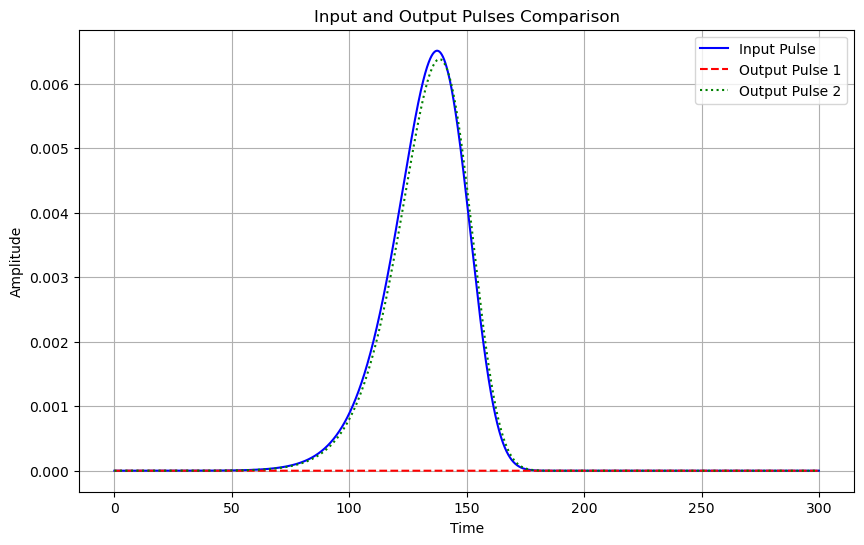

In [65]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(t_eval, pulse_in, label='Input Pulse', color='blue', linestyle='-')
plt.plot(t_eval, pulse_out1, label='Output Pulse 1', color='red', linestyle='--')
plt.plot(t_eval, pulse_out2, label='Output Pulse 2', color='green', linestyle=':')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Input and Output Pulses Comparison')
plt.grid(True)
plt.legend()
plt.show()

In [66]:
# 시간 간격
dt = t_eval[1] - t_eval[0]

# 에너지 계산 (L2 norm squared)
E_in = np.sum(pulse_in) * dt
E_out1 = np.sum(pulse_out1) * dt
E_out2 = np.sum(pulse_out2) * dt

# 비율 계산
ratio_out1 = E_out1 / E_in
ratio_out2 = E_out2 / E_in

print(f"Input Pulse Energy      : {E_in:.6f}")
print(f"Output Pulse 1 Energy   : {E_out1:.6f} ({ratio_out1:.2%} of input)")
print(f"Output Pulse 2 Energy   : {E_out2:.6f} ({ratio_out2:.2%} of input)")


Input Pulse Energy      : 0.250126
Output Pulse 1 Energy   : 0.000000 (0.00% of input)
Output Pulse 2 Energy   : 0.245120 (98.00% of input)


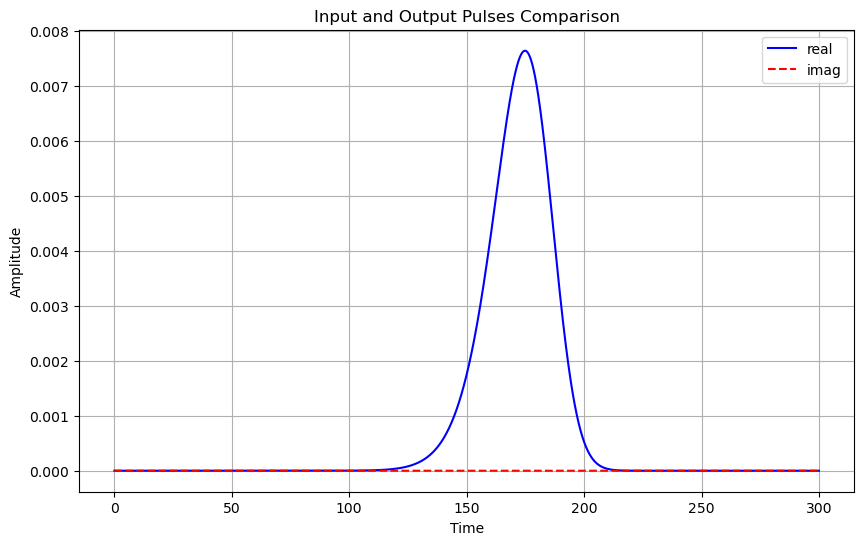

In [30]:
bbbb =  rho_t[:,2, 2]
plt.figure(figsize=(10, 6))
plt.plot(t_eval,bbbb.real, label='real', color='blue', linestyle='-')
plt.plot(t_eval, bbbb.imag, label='imag', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Input and Output Pulses Comparison')
plt.grid(True)
plt.legend()
plt.show()

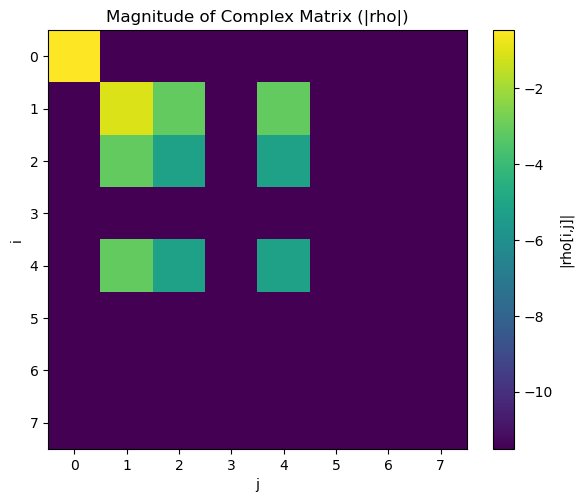

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# 절댓값 시각화 (magnitude)
plt.figure(figsize=(6, 5))
plt.imshow(np.log(np.abs(rho_t[50000])+1e-5), cmap='viridis')
plt.colorbar(label='|rho[i,j]|')
plt.title('Magnitude of Complex Matrix (|rho|)')
plt.xlabel('j')
plt.ylabel('i')
plt.tight_layout()
plt.show()

In [310]:
def microscopic_system(t, y, params, pulse, w_env, is_forward):
    a_freq, b0_freq, a_loss, b_loss, ex1, ex2, J0, param_squeeze = params
    _, _, bs_freq, _, _, Js = param_squeeze

    kappa_d = np.sqrt(2*pulse(t))
    kappa_ex1 = np.sqrt(2*ex1)
    kappa_a_i = np.sqrt(2*a_loss-2*ex1)
    kappa_b = np.sqrt(2*b_loss)

    if is_forward:
        b_freq = bs_freq
        J = Js
    else:
        b_freq = b0_freq
        J = J0

    N = len(w_env)
    gw = kappa_ex1/N

    dcw = []
    d = y[0] + 1j * y[1]
    a = y[2] + 1j * y[3]
    b = y[4] + 1j * y[5]

    da = -1j*(a_freq*a+J*b)
    db = -1j*(b_freq*b+J*a)
    dd = 0
    for ii, ww in enumerate(w_env):
        cw = y[2*ii+6]+1j*y[2*ii+7]
        hw = kappa_d/N
        da = da+1j*gw*cw
        db = db+1j*gw*cw
        dd = dd-1j*hw*cw
        dcw.append(-1j*(np.conj(hw)*d+gw*a+ww*cw))

    return [
        dd.real, dd.imag,
        da.real, da.imag,
        db.real, db.imag,
        *[item for num in dcw for item in (num.real, num.imag)]
    ]

In [311]:
import random

def solve_microsccopic_system(params, tau_p, is_forward, tau_d_scale = 5, N = 10):
    tau_d = tau_d_scale*tau_p
    _,_,a_loss,_,ex1,ex2,_,_ = params
    pulse = lambda t: a_loss * np.exp(-(t - tau_d)**2 / (2 * tau_p**2))


    w_env = np.random.uniform(-20, 20, N)
    array_length = N * 2 + 6
    y0 = [1] + [0] * (array_length-1)
    t_span = (0, 400)
    t_eval = np.linspace(*t_span, 200000)

    sol = solve_ivp(microscopic_system, t_span, y0, args=(params, pulse, w_env,  is_forward), t_eval=t_eval)
    y = sol.y
    d = y[0] + 1j * y[1]
    a = y[2] + 1j * y[3]
    b = y[4] + 1j * y[5]

    return t_eval, y, w_env

In [312]:
tau_p = 2*np.pi*6
t_eval, y, w_env = solve_microsccopic_system(
    param_reproduce(
        kappa_ext=0.99,
        delta=0,
        J0=0.99,
        b_freq_p=10.3,
        pump=10
    ),
    tau_p,
    True,
)



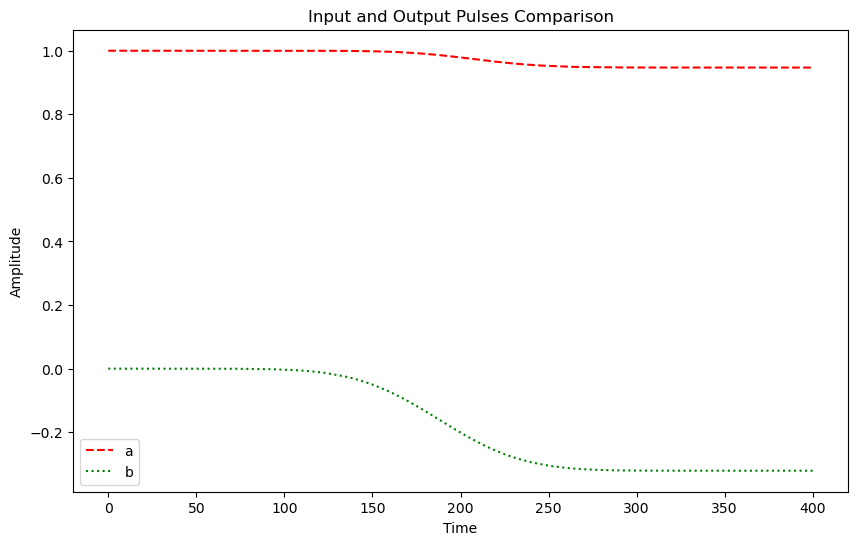

In [315]:
d = y[0] + 1j * y[1]
a = y[2] + 1j * y[3]
b = y[4] + 1j * y[5]

plt.figure(figsize=(10, 6))
#plt.plot(t_eval, d.imag, label='d', color='blue', linestyle='-')
plt.plot(t_eval, y[0], label='a', color='red', linestyle='--')
plt.plot(t_eval, y[1], label='b', color='green', linestyle=':')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Input and Output Pulses Comparison')
plt.grid(False)
plt.legend()
plt.show()

In [297]:
w_env

array([ -9.02447002,  15.83235453, -17.78152475,   3.61733379,
       -13.69731155,  -0.61414456, -19.66833186,  18.25672759,
        19.69392081,   6.32319018])